In [31]:
import pandas as pd

# Load the dataset with a specified encoding
data = pd.read_csv(r'C:\Users\HP\Downloads\Project\OnlineRetail.csv', encoding='ISO-8859-1')


# Data was imported here with some encodings.


In [32]:
# Data cleaning
data.dropna(subset=['CustomerID'], inplace=True)  # Drop rows without CustomerID
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')  # Convert to datetime


In [33]:
# Calculate total price
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']  # Use UnitPrice

# RFM Calculation
current_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
})

# Print the aggregated DataFrame before renaming
print("Aggregated DataFrame:")
print(rfm.head())

Aggregated DataFrame:
            InvoiceDate  InvoiceNo  TotalPrice
CustomerID                                    
12346.0             326          2        0.00
12347.0               2        182     4310.00
12348.0              75         31     1797.24
12349.0              19         73     1757.55
12350.0             310         17      334.40


In [34]:
# Rename the columns and assign to a new variable
rfm_renamed = rfm.rename(columns={
    'InvoiceDate': 'Recency', 
    'InvoiceNo': 'Frequency', 
    'TotalPrice': 'Monetary'
})

# Check the RFM DataFrame columns after renaming
print("RFM DataFrame columns after renaming:")
print(rfm_renamed.columns)


RFM DataFrame columns after renaming:
Index(['Recency', 'Frequency', 'Monetary'], dtype='object')


In [35]:
# Segmenting customers using the renamed DataFrame
rfm_renamed['RFMScore'] = rfm_renamed['Recency'].rank(ascending=False) + rfm_renamed['Frequency'].rank() + rfm_renamed['Monetary'].rank()

# Display the RFM DataFrame with RFMScore
print(rfm_renamed.head())


            Recency  Frequency  Monetary  RFMScore
CustomerID                                        
12346.0         326          2      0.00     322.5
12347.0           2        182   4310.00   12122.5
12348.0          75         31   1797.24    6872.5
12349.0          19         73   1757.55    9416.5
12350.0         310         17    334.40    2620.5


In [48]:
def segment_customers(row):
    if row['RFMScore'] >= 5000:
        return 'High Value'
    elif row['RFMScore'] >= 1000:
        return 'Medium Value'
    else:
        return 'Low Value'

rfm_renamed['Segment'] = rfm_renamed.apply(segment_customers, axis=1)

# Display the updated DataFrame with segments

print(rfm_renamed[['Recency', 'Frequency', 'Monetary', 'RFMScore', 'Segment']].head())
print(rfm_renamed['Segment'].value_counts())

            Recency  Frequency  Monetary  RFMScore       Segment
CustomerID                                                      
12346.0         326          2      0.00     322.5     Low Value
12347.0           2        182   4310.00   12122.5    High Value
12348.0          75         31   1797.24    6872.5    High Value
12349.0          19         73   1757.55    9416.5    High Value
12350.0         310         17    334.40    2620.5  Medium Value
High Value      2812
Medium Value    1460
Low Value        100
Name: Segment, dtype: int64


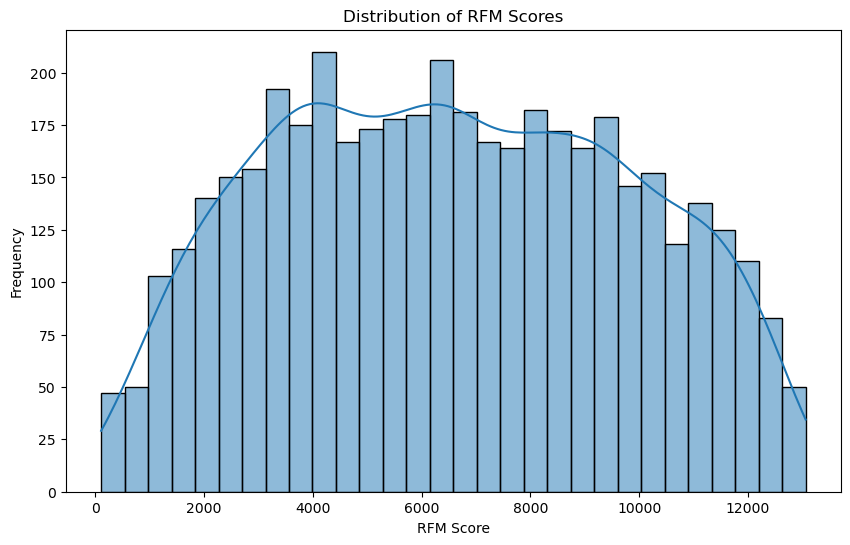

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(rfm_renamed['RFMScore'], bins=30, kde=True)
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Frequency')
plt.show()

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


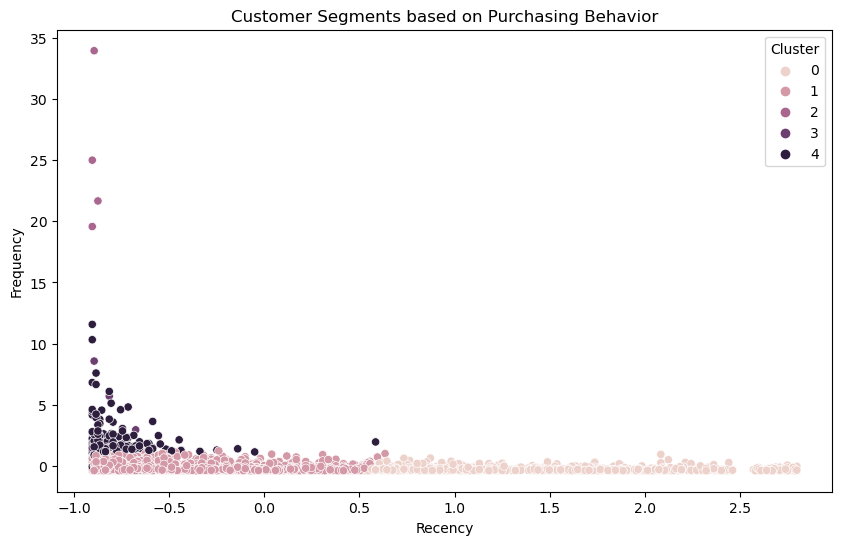

In [38]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Assuming rfm_renamed is your DataFrame with 'Recency', 'Frequency', and 'Monetary'
customer_data = rfm_renamed[['Recency', 'Frequency', 'Monetary']]

# Scale the data using StandardScaler
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data)

# Convert scaled data back to DataFrame
customer_data_scaled = pd.DataFrame(customer_data_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data_scaled['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=customer_data_scaled)
plt.title('Customer Segments based on Purchasing Behavior')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()

# Scatter Plot: The plot will display points representing customers, where:
# X-axis: Represents the Recency of purchases (how recently a customer has made a purchase).
# Y-axis: Represents the Frequency of purchases (how often a customer makes purchases).
# Colored Clusters: Each point will be colored according to the cluster it belongs to, which is determined by the K-Means algorithm. Different colors will indicate different customer segments based on their purchasing behaviors.

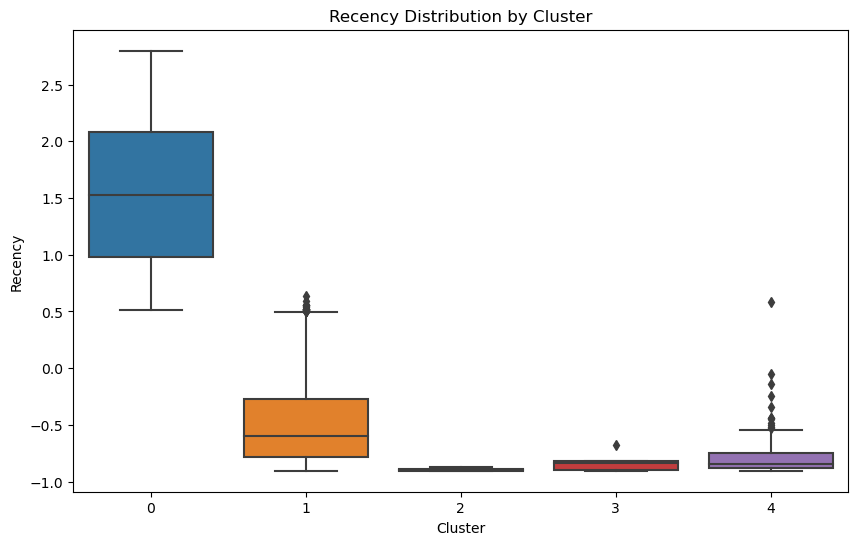

                    Recency  Frequency  Monetary
Cluster                                         
0       Recency    1.000000  -0.164405 -0.112790
        Frequency -0.164405   1.000000  0.380576
        Monetary  -0.112790   0.380576  1.000000
1       Recency    1.000000  -0.263561 -0.204711
        Frequency -0.263561   1.000000  0.549276
        Monetary  -0.204711   0.549276  1.000000
2       Recency    1.000000  -0.046218 -0.239540
        Frequency -0.046218   1.000000  0.000630
        Monetary  -0.239540   0.000630  1.000000
3       Recency    1.000000  -0.197010 -0.801862
        Frequency -0.197010   1.000000  0.197068
        Monetary  -0.801862   0.197068  1.000000
4       Recency    1.000000  -0.105069 -0.159506
        Frequency -0.105069   1.000000  0.144023
        Monetary  -0.159506   0.144023  1.000000


In [39]:
# Calculate descriptive statistics for each cluster
cluster_stats = customer_data_scaled.groupby('Cluster').describe()

# Visualize the distribution of values for each cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Recency', data=customer_data_scaled)
plt.title('Recency Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency')
plt.show()

# Analyze correlation between variables within each cluster
cluster_corr = customer_data_scaled.groupby('Cluster').corr()
print(cluster_corr)

In [40]:
# Identify customers in clusters with low recency
inactive_customers = customer_data_scaled[customer_data_scaled['Recency'] > 30]

# Develop strategies to re-engage inactive customers
re_engagement_strategy = inactive_customers['Cluster'].value_counts()
print(re_engagement_strategy)

# Identify customers in clusters with high frequency
high_frequency_customers = customer_data_scaled[customer_data_scaled['Frequency'] > 5]

# Develop strategies to upsell/cross-sell products
upsell_strategy = high_frequency_customers['Cluster'].value_counts()
print(upsell_strategy)

Series([], Name: Cluster, dtype: int64)
4    7
2    4
3    2
Name: Cluster, dtype: int64


In [41]:
# Check descriptive statistics of the scaled data
print(customer_data_scaled.describe())

# Set new thresholds based on the scaled values
# Adjust these values according to the descriptive statistics
inactive_customers = customer_data_scaled[customer_data_scaled['Recency'] > 1]  # Adjusted threshold
re_engagement_strategy = inactive_customers['Cluster'].value_counts()
print("Re-engagement Strategy:\n", re_engagement_strategy)

# Identify customers in clusters with high frequency
high_frequency_customers = customer_data_scaled[customer_data_scaled['Frequency'] > 1]  # Adjusted threshold
upsell_strategy = high_frequency_customers['Cluster'].value_counts()
print("Upsell Strategy:\n", upsell_strategy)

            Recency     Frequency     Monetary      Cluster
count  4.372000e+03  4.372000e+03  4372.000000  4372.000000
mean  -4.225551e-17  9.751273e-18     0.000000     0.923376
std    1.000114e+00  1.000114e+00     1.000114     0.860869
min   -9.036584e-01 -3.960218e-01    -0.752712     0.000000
25%   -7.448556e-01 -3.271883e-01    -0.195305     1.000000
50%   -4.173249e-01 -2.196360e-01    -0.152144     1.000000
75%    5.057162e-01  3.848956e-02    -0.034889     1.000000
max    2.798431e+00  3.394328e+01    33.776695     4.000000
Re-engagement Strategy:
 0    787
Name: Cluster, dtype: int64
Upsell Strategy:
 4    187
1     13
3      5
2      4
Name: Cluster, dtype: int64


In [42]:
# Calculate total sales
data['TotalSales'] = data['Quantity'] * data['UnitPrice']
# Total sales
total_sales = data['TotalSales'].sum()
print(f'Total Sales: {total_sales}')

# Unique customers
unique_customers = data['CustomerID'].nunique()
print(f'Unique Customers: {unique_customers}')

# Top 10 products by total sales
top_products = data.groupby('Description')['TotalSales'].sum().nlargest(10)
print("Top 10 Products by Total Sales:")
print(top_products)

# Sales by country
sales_by_country = data.groupby('Country')['TotalSales'].sum().sort_values(ascending=False)
print("Sales by Country:")
print(sales_by_country)

Total Sales: 8300065.814000001
Unique Customers: 4372
Top 10 Products by Total Sales:
Description
REGENCY CAKESTAND 3 TIER              132870.40
WHITE HANGING HEART T-LIGHT HOLDER     93823.85
JUMBO BAG RED RETROSPOT                83236.76
PARTY BUNTING                          67687.53
POSTAGE                                66710.24
ASSORTED COLOUR BIRD ORNAMENT          56499.22
RABBIT NIGHT LIGHT                     51137.80
CHILLI LIGHTS                          45936.81
PAPER CHAIN KIT 50'S CHRISTMAS         41500.48
PICNIC BASKET WICKER 60 PIECES         39619.50
Name: TotalSales, dtype: float64
Sales by Country:
Country
United Kingdom          6767873.394
Netherlands              284661.540
EIRE                     250285.220
Germany                  221698.210
France                   196712.840
Australia                137077.270
Switzerland               55739.400
Spain                     54774.580
Belgium                   40910.960
Sweden                    36595.910
Jap

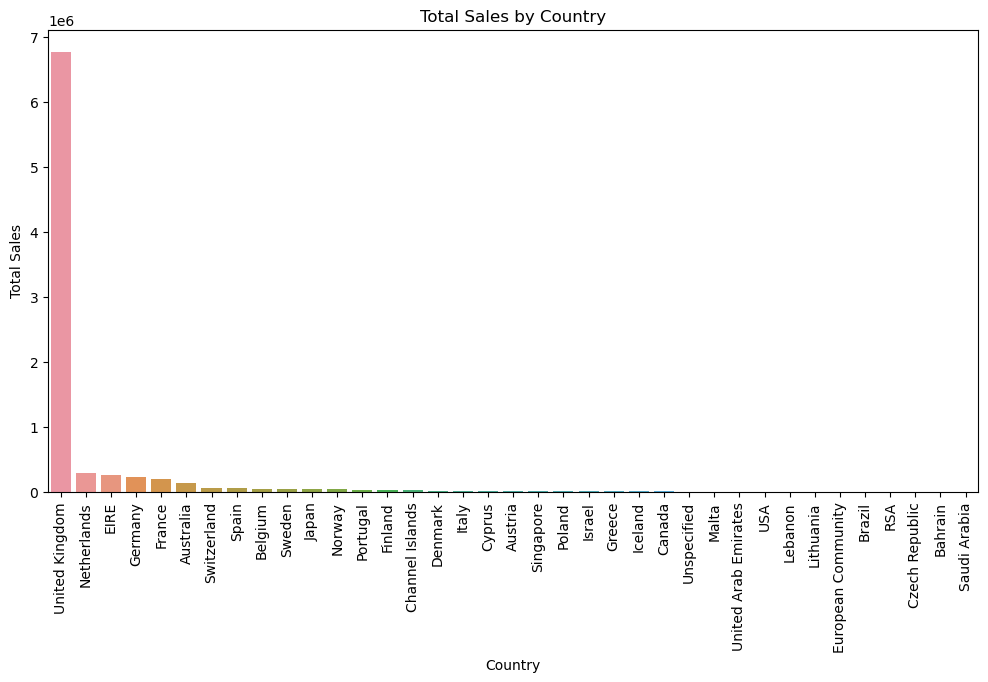

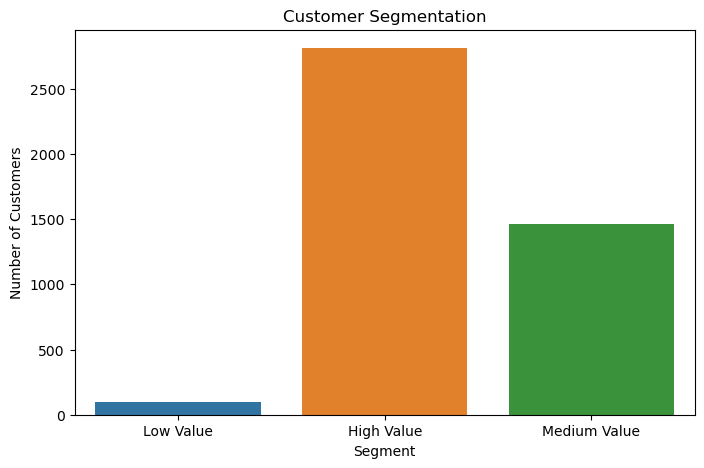

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sales by country
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_country.index, y=sales_by_country.values)
plt.xticks(rotation=90)
plt.title('Total Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.show()

# Plot RFM segments
plt.figure(figsize=(8, 5))
sns.countplot(x='Segment', data=rfm_renamed)
plt.title('Customer Segmentation')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()

In [21]:
# Check the columns of the rfm DataFrame
print(rfm.columns)

# Display the first few rows of the DataFrame to verify the Segment column
print(rfm.head())

Index(['InvoiceDate', 'InvoiceNo', 'TotalPrice'], dtype='object')
            InvoiceDate  InvoiceNo  TotalPrice
CustomerID                                    
12346.0             326          2        0.00
12347.0               2        182     4310.00
12348.0              75         31     1797.24
12349.0              19         73     1757.55
12350.0             310         17      334.40
